In [3]:
import os

# pip install charset-normalizer==2.1.0
from fer import FER
import matplotlib.pyplot as plt 
import matplotlib.patches as patches
import pandas as pd
from exif import Image as exifImage
from pillow_heif import register_heif_opener
from matplotlib.pyplot import figure
import numpy as np
import seaborn as sns
from PIL import Image
from PIL.ImageOps import exif_transpose

register_heif_opener()

OVERWRITE_FILE = False

In [4]:
data_dir = './Data'
image_dir = os.path.join(data_dir, 'rawfaces', 'myface')
faces = os.listdir(image_dir)
detector = FER(mtcnn=True)

if OVERWRITE_FILE:
    with open(f'{data_dir}/raw_emotion_data.csv', 'w') as f:
        emotions = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']
        f.write(','.join(['id', 'filename', 'date_created', 'box_x', 'box_y', 'box_width', 'box_height', *emotions]) + '\n')


In [3]:
def draw_image(img=None, image_path=None, box=None, emotions=None, crop=False, border=False, output_data_dir=None, output_filename=None, show=True):
    """
    Usage:
    row = emotion_data.iloc[0]
    draw_image(row.filename, row[2:6])
    """
    if img is None:
        img = plt.imread(image_path)

    _, ax = plt.subplots(1)
    im = plt.imshow(img)

    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)

    if box is not None:
        x0, x1 = box[0], box[0] + box[2]
        y0, y1 = box[1], box[1] + box[3]

        # im.axes.add_patch(plt.Rectangle((x0, y0), x1 - x0, y1 - y0, fill=False, edgecolor='red', linewidth=2))
        ax = plt.gca()

        y_size, x_size = im.get_size()

        if crop:
            x_border = int(x_size * 0.02) if border else 0
            y_border = int(y_size * 0.02) if border else 0

            ax.set_xlim([max(0, x0 - x_border), min(x_size, x1 + x_border)])
            ax.set_ylim([min(y_size,y1 + y_border), max(0, y0 - y_border)])

        if emotions is not None:
            emotion_annotion_y = 0.9
            for emotion, score in emotions.items():
                plt.annotate(f'{emotion}: {score:.2f}', xy=(0.1, emotion_annotion_y), xycoords='axes fraction', textcoords='axes fraction', ha='left', va='top', fontsize=12)
                emotion_annotion_y -= 0.1

    if output_data_dir:
        plt.savefig(os.path.join(output_data_dir, output_filename), dpi=300, bbox_inches='tight', pad_inches=0)

    if show:
        plt.show()


In [ ]:
%%capture

emotion_data = pd.read_csv(f'{data_dir}/raw_emotion_data.csv')
existing_files = set(emotion_data.filename)

i = len(emotion_data) + 1
for image_name in faces:
    if image_name in existing_files:
        continue

    img_path = os.path.join(image_dir, image_name)

    try:
        img_metadata = exifImage(img_path)
        date_taken = img_metadata.get('datetime_original')
    except:
        date_taken = 'None'

    try:
        img = np.asarray(exif_transpose(Image.open(img_path)))
        image_faces = detector.detect_emotions(img)
    except:
        continue

    with open(f'{data_dir}/raw_emotion_data.csv', 'a') as f:
        for face in image_faces:
            box = face['box']
            image_area = box[2] * box[3]
            if image_area < 10000:
                continue
            row = [i, image_name, date_taken, *box, *face['emotions'].values()]
            draw_image(img, box=box, crop=True, border=False, output_data_dir='./Data/croppedfaces', output_filename=str(i))
            f.write(','.join([str(x) for x in row]) + '\n')
            i += 1


In [ ]:
raw_emotion_data = pd.read_csv(f'{data_dir}/raw_emotion_data.csv')
cropped_faces_dir = os.path.join(data_dir, 'croppedfaces')
filtered_faces = os.listdir(cropped_faces_dir)
filtered_indices = [int(filename.split('.')[0]) for filename in filtered_faces]
filtered_emotion_data = raw_emotion_data[raw_emotion_data.id.isin(filtered_indices)]

filenames_to_be_adjusted = ['IMG_5203.JPG', 'IMG_5209.JPG', 'IMG_5223.JPG', 'IMG_5203.JPG', 'IMG_5232 (2).JPG', 'IMG_5240.JPG', 'IMG_5249.JPG']
filtered_emotion_data.date_created[filtered_emotion_data.filename.isin(filenames_to_be_adjusted)] = filtered_emotion_data.date_created[filtered_emotion_data.filename.isin(filenames_to_be_adjusted)].replace('2014:', '2018:', regex=True)

filtered_emotion_data.date_created = filtered_emotion_data.date_created.replace('-', ':', regex=True)
filtered_emotion_data.date_created = pd.to_datetime(filtered_emotion_data.date_created, format="%Y:%m:%d %H:%M:%S", errors='coerce')
filtered_emotion_data = filtered_emotion_data.dropna()
filtered_emotion_data = filtered_emotion_data.sort_values(by='date_created')

filtered_emotion_data.to_csv(os.path.join(data_dir, 'filtered_emotion_data.csv'), index=False)

In [ ]:
%%capture
import imageio
from tqdm import tqdm
import io

gif_df = pd.read_csv(os.path.join(data_dir, 'filtered_emotion_data.csv'))

with imageio.get_writer('timelapse3.gif', mode='I') as writer:
    for row in tqdm(gif_df.iterrows()):
        row = row[1]
        file_no = row.id
        year = row.date_created[:4]
        if file_no == 2069:
            continue
        filename = str(file_no) + '.png'
        image = imageio.v2.imread(os.path.join(cropped_faces_dir, filename))[::4, ::4, :]
        fig, ax = plt.subplots(1)
        ax.imshow(image)
        ax.annotate(f'{year}', xy=(0.01, 0.01), xycoords='axes fraction', textcoords='axes fraction', ha='left', va='bottom', fontsize=20)
        y_pos = 0.99
        for emotion, score in row[7:].items():
            ax.annotate(f'{emotion}: {int(score*100)}%', xy=(0.01, y_pos), xycoords='axes fraction', textcoords='axes fraction', ha='left', va='top', fontsize=12, color='red')
            y_pos -= 0.05

        ax.axis("off")
        ax.figure.canvas.draw()
        buff = io.BytesIO()
        plt.savefig(buff, format="png", bbox_inches='tight', pad_inches=0)
        buff.seek(0)
        image = plt.imread(buff)
        writer.append_data(image)
        plt.close(fig)


In [ ]:
filtered_faces = os.listdir(os.path.join(data_dir, 'croppedfaces'))
filtered_indices = [int(filename.split('.')[0]) for filename in filtered_faces]
filtered_emotion_data = raw_emotion_data[raw_emotion_data.index.isin(filtered_indices)]
filtered_emotion_data.to_csv(os.path.join(data_dir, 'emotion_data.csv'), index=False)


The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.




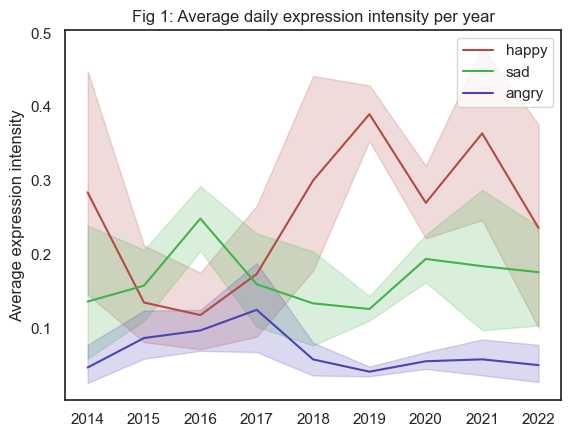

In [44]:
emotion_data = pd.read_csv(f'{data_dir}/filtered_emotion_data.csv')

emotion_data.date_created = emotion_data.date_created.replace('-', ':', regex=True)
emotion_data.date_created = pd.to_datetime(emotion_data.date_created, format="%Y:%m:%d %H:%M:%S", errors='coerce')
emotion_data = emotion_data.dropna()
emotion_data = emotion_data.sort_values(by='date_created')

emotion_data['dominant_emotion'] = emotion_data[
    ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']].idxmax(axis=1)
emotion_data['year'] = emotion_data.date_created.dt.year
emotion_data['time'] = emotion_data.date_created.dt.strftime('%b %Y')
emotion_data['day'] = emotion_data.date_created.dt.strftime('%y %j')

emotion_data = emotion_data.groupby('day').mean()

emotions = ['angry', 'happy', 'sad']
colours = {'red': '#b34b42', 'green': '#42b34b', 'blue': '#4b42b3'}

figure(num=None, facecolor='w', edgecolor='k')

ax = sns.lineplot(x='year',
                  y='value',
                  hue='variable',
                  data=pd.melt(emotion_data.query('year > 2013'), ['year'], value_vars=['happy', 'sad', 'angry']),
                  sort=False,
                  palette=colours.values(),
                  err_style='band',
                  err_kws={'alpha': 0.2})

ax.set(xlabel='',
       ylabel='Average expression intensity',
       title='Fig 1: Average daily expression intensity per year')


plt.legend(title='')
plt.savefig('Output/emotions_over_time.png', dpi=300)
plt.show()



<Figure size 1440x480 with 0 Axes>

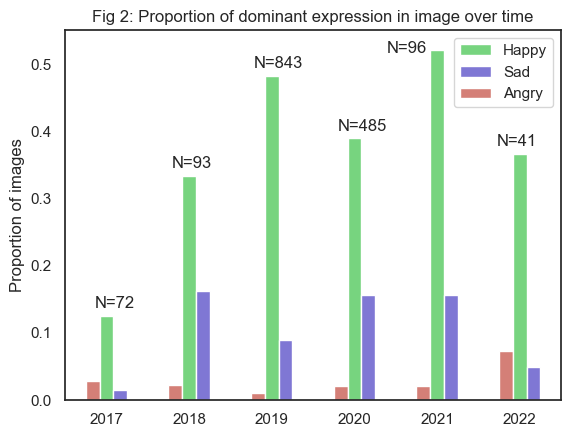

In [45]:
emotion_data = pd.read_csv(f'{data_dir}/filtered_emotion_data.csv')
emotion_data.date_created = emotion_data.date_created.replace('-', ':', regex=True)
emotion_data.date_created = pd.to_datetime(emotion_data.date_created, format="%Y:%m:%d %H:%M:%S", errors='coerce')
emotion_data = emotion_data.dropna()
emotion_data = emotion_data.sort_values(by='date_created')
emotion_data['dominant_emotion'] = emotion_data[
    ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']].idxmax(axis=1)
emotion_data['year'] = emotion_data.date_created.dt.year
emotion_data['time'] = emotion_data.date_created.dt.strftime('%b %Y')
emotion_data['day'] = emotion_data.date_created.dt.strftime('%y %j')

sns.set(style='white')

by_year = emotion_data.groupby(['year']).size()
dominant_emotions = emotion_data.groupby(['year', 'dominant_emotion']).size() / by_year
dominant_emotions = dominant_emotions.reset_index()
dominant_emotions.replace({'dominant_emotion': {'angry': 'Angry', 'disgust': None, 'fear': None, 'happy': 'Happy', 'sad': 'Sad', 'surprise': None, 'neutral': None}}, inplace=True)
dominant_emotions = dominant_emotions.groupby(['year', 'dominant_emotion']).sum().reset_index()
dominant_emotions = dominant_emotions.query('year > 2016')

dominant_emotions = dominant_emotions.pivot(index='year', columns='dominant_emotion', values=0).reset_index()

dominant_emotions.columns = pd.CategoricalIndex(dominant_emotions.columns.values,
                                 ordered=True,
                                 categories=['year', 'Angry', 'Happy', 'Sad'])

# Sort the columns (axis=1) by the new categorical ordering
dominant_emotions = dominant_emotions.sort_index(axis=1)


figure(num=None, figsize=(12, 4), dpi=120, facecolor='w', edgecolor='k')
ax = dominant_emotions.set_index('year').plot(kind='bar',
                                              stacked=False,
                                              color=['#d47f77', '#77d47f', '#7f77d4', '#dbdbdb'],
                                              rot=0,
                                              xlabel='',
                                              ylabel='Proportion of images',
                                              title='Fig 2: Proportion of dominant expression in image over time',
                                              ylim=(0, 0.55))

handles, labels = ax.get_legend_handles_labels()
handles = [handles[1], handles[2], handles[0]]
labels = [labels[1], labels[2], labels[0]]
ax.legend(handles, labels)

x_pos = [0.1, 0.255, 0.43, 0.60, 0.69, 0.91]
y_pos = [0.26, 0.64, 0.91, 0.74, 0.95, 0.7]
for i, N in enumerate(by_year[by_year.index > 2016]):
    ax.annotate(f'N={N}', xy=(x_pos[i], y_pos[i]), xycoords='axes fraction', textcoords='axes fraction', ha='center', va='center', fontsize=12)

plt.savefig('Output/dominant_emotion_over_time.png', dpi=300)


In [46]:
import plotly.graph_objects as go

filtered_emotion_data = pd.read_csv(f'{data_dir}/filtered_emotion_data.csv')
other_emotion_data = pd.read_csv(f'{data_dir}/not_me_emotion_data.csv')

emotions = ['angry', 'fear', 'happy', 'sad', 'surprise', 'neutral']
filtered_emotion_data['dominant_emotion'] = filtered_emotion_data[emotions].idxmax(axis=1)
other_emotion_data['dominant_emotion'] = other_emotion_data[emotions].idxmax(axis=1)

# Compute the mean value for each emotion over the images where it is the dominant emotion
filtered_emotion_data = filtered_emotion_data.groupby(['dominant_emotion']).mean().reset_index()

d1, d2 = {}, {}
for emotion in emotions:
    value1 = filtered_emotion_data.loc[filtered_emotion_data['dominant_emotion'] == emotion, emotion]
    value2 = other_emotion_data.loc[other_emotion_data['dominant_emotion'] == emotion, emotion]
    d1[emotion] = value1.values[0]
    d2[emotion] = value2.values[0]

d1 = pd.DataFrame.from_dict(d1, orient='index', columns=['data'])['data']

d2 = pd.DataFrame.from_dict(d2, orient='index', columns=['data'])['data']

fig = go.Figure(layout=go.Layout(title=go.layout.Title(text="Fig 3: Mean (dominant) expression intensity"), template='plotly_white'))

fig.add_trace(go.Scatterpolar(
    r=d2,
    theta=emotions,
    fill='toself',
    name='Not me'
))

fig.add_trace(go.Scatterpolar(
    r=d1,
    theta=emotions,
    fill='toself',
    name='Me'
))


fig.update_layout(
    polar=dict(
        radialaxis=dict(
            visible=True,
            range=[0, 1]
        )),
    showlegend=True,
    width=400,
    height=400
)

fig.show()

fig.write_image("Output/dominant_emotion_distribution.png")



The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.




In [ ]:
all_emotion_data = pd.read_csv(f'{data_dir}/filtered_emotion_data.csv')

emotions = ['angry', 'fear', 'happy', 'sad', 'surprise', 'neutral']
for emotion in emotions:

    row = all_emotion_data.sort_values(by=[emotion], ascending=False).head(10)
    i = 0 if emotion != 'happy' else 2
    image_path = f'{data_dir}/croppedfaces/{row.id.values[i]}.png'
    draw_image(image_path=image_path, show=False)
    ax = plt.gca()

    year = row.date_created.values[i].split('-')[0]
    ax.annotate(f'{year}', xy=(0.01, 0.01), xycoords='axes fraction', textcoords='axes fraction', ha='left', va='bottom', fontsize=22, color='red')

    score = row[emotion].values[i]
    ax.annotate(f'{emotion}: {int(score*100)}%', xy=(0.02, 0.98), xycoords='axes fraction', textcoords='axes fraction', ha='left', va='top', fontsize=18, color='red')
    plt.savefig(f'Output/most_potent/{emotion}.png', dpi=300, bbox_inches='tight')
    plt.show()

